# LangGraph: Code Assistant

## Code generation with RAG and self-correction

- Code Assistant<br>
  https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/
- All models overview<br>
  https://docs.anthropic.com/en/docs/about-claude/models/all-models

## SETUP

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables (for API key)
load_dotenv()

# Set up OpenAI API key
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Please set the OPENAI_API_KEY environment variable or add it to a .env file")

# Define the model to use
MODEL_GPT = "gpt-4o-mini"

## SETUP (LangGraph)

In [2]:
# ! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

MODEL_GPT = "gpt-4o-mini"
MODEL_CLAUDE = "claude-3-5-haiku-latest"  # claude-3-5-haiku-20241022
# MODEL_CLAUDE = "claude-3-7-sonnet-latest"  # claude-3-7-sonnet-20250219

## Docs

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [5]:
# docs
# len(docs)
# print(docs[0].page_content)
print(docs[0])

page_content='




LangChain Expression Language (LCEL) | 🦜️🔗 LangChain






Skip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model r

## LLMs

### OpenAI (gpt-4o-mini)

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='To build a Retrieval Augmented Generation (RAG) chain in LCEL, you can utilize the combination of a retriever and a language model (LLM) to generate responses based on retrieved documents. The RAG chain typically involves first retrieving relevant documents based on a query and then using those documents to generate a response. In LCEL, you can achieve this by composing a sequence of runnables that includes the retriever and the LLM. Here’s how you can do it:', imports='from langchain_core.runnables import RunnableSequence\nfrom langchain_core.runnables import RunnableParallel\nfrom langchain_core.runnables import RunnableLambda\n\n# Assuming you have a retriever and an LLM defined as retriever and llm respectively', code='# Define the RAG chain\nrag_chain = RunnableSequence([\n    retriever,  # Step 1: Retrieve relevant documents\n    llm          # Step 2: Generate response using the retrieved documents\n])\n\n# Invoke the RAG chain with a query\nquery = "What are the be

### Anthropic (claude-3-5-haiku-latest)

In [7]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# LLM
# expt_llm = "claude-3-opus-20240229"
expt_llm = MODEL_CLAUDE
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

structured_llm_claude = llm.with_structured_output(code, include_raw=True)

# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output

# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)

def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }

# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)

def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]

# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [8]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='This example demonstrates building a Retrieval Augmented Generation (RAG) chain using LangChain Expression Language (LCEL). The chain will:\n1. Use a vector store retriever to find relevant documents\n2. Create a prompt that combines the query and retrieved context\n3. Use a chat model to generate a response based on the retrieved context\n4. Optionally parse the output', imports='from langchain_community.vectorstores import FAISS\nfrom langchain_openai import OpenAIEmbeddings, ChatOpenAI\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.runnables import RunnablePassthrough', code='# Create embeddings and vector store\nembeddings = OpenAIEmbeddings()\nvectorstore = FAISS.from_texts(\n    ["LangChain is a framework for developing LLM applications", \n     "RAG helps provide context to language models"],\n    embedding=embeddings\n)\n\n# Create retriever\nretriever = vectorstore.as_retriever

## State

In [9]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

## Graph

In [10]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes

def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

### Edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [11]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [12]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
content='Artificial intelligence (AI) is a branch of computer science that focuses on creating intelligent machines that can perform tasks that typically require human intelligence. AI technology enables machines to learn from data, make decisions, and solve complex problems without direct human intervention. AI applications include speech recognition, image recognition, self-driving cars, virtual assistants, and more. Despite the potential benefits of AI, there are also concerns about its impact on jobs, privacy, and ethics. Ongoing research and development are key to harnessing the power of AI while addressing these challenges.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 14, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio

In [13]:
solution["generation"]

code(prefix="This example demonstrates how to pass a string directly to a runnable and use it to construct input for a prompt template. We'll use RunnableLambda to transform the input string and then pass it to a prompt template.", imports='from langchain_core.prompts import PromptTemplate\nfrom langchain_core.runnables import RunnableLambda\nfrom langchain_openai import ChatOpenAI', code='# Create a function to transform the input string\ndef format_input(input_str):\n    return {"topic": input_str}\n\n# Create a prompt template\nprompt = PromptTemplate.from_template(\n    "Write a short summary about {topic}"\n)\n\n# Create a chain that transforms the input and then uses it in the prompt\nchain = (\n    RunnableLambda(format_input)  # Convert string to dict with \'topic\' key\n    | prompt  # Pass the formatted input to the prompt template\n    | ChatOpenAI()  # Use an OpenAI chat model to generate the summary\n)\n\n# Example usage\nresult = chain.invoke("artificial intelligence")\np

## Eval

Public dataset of LCEL questions
- [lcel-teacher-eval](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d)
- as CSV [eval.csv](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv)

In [14]:
import langsmith

client = langsmith.Client()

In [15]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

### Custom evals

In [16]:
from langsmith.schemas import Example, Run

def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}

def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

### Compare LangGraph to Context Stuffing

In [17]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    return {"imports": solution.imports, "code": solution.code}

def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke(
        {"messages": [("user", example["question"])], "iterations": 0, "error": ""}
    )
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [18]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "lcel-teacher-eval"

In [19]:
# Run base case
try:
    experiment_results_ = evaluate(
        predict_base_case,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-without-langgraph-{expt_llm}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
        },
    )
except:
    print("Please setup LangSmith")

C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'test-without-langgraph-claude-3-5-haiku-latest-14683ff2' at:
https://smith.langchain.com/o/a616d0a1-f75e-4fa3-bbfd-b7fbabf719b6/datasets/35dec0a3-3633-4bd5-bae2-739f53da6a1b/compare?selectedSessions=0c2a0219-0ffc-400b-8549-73ebf2b49f2f




4it [00:27,  6.84s/it]

"HELLO" is a common greeting used to acknowledge someone's presence or to initiate a conversation. It is often used as a friendly way to say hi or to begin a conversation with someone.


5it [00:30,  5.53s/it]

{'a': 1, 'b': 2, 'c': 3}


6it [00:34,  5.08s/it]

<class 'langchain_core.utils.pydantic.PromptInput'>

# Schema type:
<class 'pydantic._internal._model_construction.ModelMetaclass'>


8it [00:45,  5.20s/it]

Result 1 (full output as string): content='Why do programmers prefer dark mode? Because the light attracts bugs!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 14, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BFGQOo8Xwe5GxalqQRN9YU3ODY0xG', 'finish_reason': 'stop', 'logprobs': None} id='run-d3aeb2c9-61b3-4418-a2d2-e0110b97a89e-0' usage_metadata={'input_tokens': 14, 'output_tokens': 14, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Result 2 (content as string): Why do programmers prefer dark mode? Because the light attracts too many bugs!
Type of result1: <class 'str'>
Type of result2

9it [00:50,  5.26s/it]

Method 1 (itemgetter): What is LCEL?
Method 2 (lambda): What is LCEL?
Method 3 (.get()): What is LCEL?
itemgetter KeyError: 'nonexistent'
lambda KeyError: 'nonexistent'
Safe retrieval with .get(): None
Safe retrieval with default value: Default Question


12it [01:08,  5.47s/it]

name='John Doe' age=30 hobbies=['hiking', 'camping', 'rock climbing']
<class '__main__.Person'>


13it [01:14,  5.81s/it]

"HELLO WORLD" is a common phrase used in computer programming as a simple introductory message printed to the screen. It is often the first program that new programmers write as a way to learn the basics of coding. This phrase serves as a standard starting point to test that a program is functioning correctly and to signal the beginning of a new coding project.


14it [01:21,  6.12s/it]

Why do programmers prefer dark mode? Because the light attracts bugs!


16it [01:26,  4.53s/it]

content='Sure, here you go: "Why did the scarecrow win an award? Because he was outstanding in his field!"' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 22, 'total_tokens': 47, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BFGR2EgVGwrXZsLxwJV5B571SeswH', 'finish_reason': 'stop', 'logprobs': None} id='run-ce590dac-dabf-4755-8346-6e4c8bbc73dc-0' usage_metadata={'input_tokens': 22, 'output_tokens': 25, 'total_tokens': 47, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Sure, here you go: "Why did the scarecrow win an award? Because he was outstanding in his field!"


17it [01:30,  4.32s/it]

{'first_result': 'Processed first chain: Hello, parallel processing!', 'second_result': 'Processed second chain: Hello, parallel processing!'}


18it [01:37,  4.95s/it]

content='Artificial intelligence, or AI, refers to the simulation of human intelligence by computers and machines. This technology allows computers to perform tasks that would normally require human intelligence, such as problem-solving, decision-making, and learning. AI is used in various fields, including healthcare, finance, and transportation, and is continuing to advance at a rapid pace. While AI has the potential to greatly benefit society by improving efficiency and productivity, there are also concerns about its impact on the job market and ethical implications.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 14, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcm

20it [01:39,  4.98s/it]


In [20]:
# Run with langgraph
try:
    experiment_results = evaluate(
        predict_langgraph,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-with-langgraph-{expt_llm}-{flag}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
            "feedback": flag,
        },
    )
except:
    print("Please setup LangSmith")

View the evaluation results for experiment: 'test-with-langgraph-claude-3-5-haiku-latest-do not reflect-ac329c6b' at:
https://smith.langchain.com/o/a616d0a1-f75e-4fa3-bbfd-b7fbabf719b6/datasets/35dec0a3-3633-4bd5-bae2-739f53da6a1b/compare?selectedSessions=32e94265-b723-4a8c-b4e0-2acc1ca496d7




0it [00:00, ?it/s]

---GENERATING CODE SOLUTION---
---GENERATING CODE SOLUTION---


1it [00:09,  9.60s/it]

---CHECKING CODE---
Lambda serves three key purposes in LCEL:
1. Extracts specific key from input dictionary
2. Transforms input for the next step in the chain
3. Enables automatic type coercion to RunnableLambda
Extracted value: how do I use Anthropic?
---NO CODE TEST FAILURES---
---DECISION: FINISH---
Lambda serves three key purposes in LCEL:
1. Extracts specific key from input dictionary
2. Transforms input for the next step in the chain
3. Enables automatic type coercion to RunnableLambda
Extracted value: how do I use Anthropic?
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


2it [00:24, 12.65s/it]

---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
content='Dove ha lavorato Harrison?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 19, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BFGS0g1AaeJkOaWO28JCiVTBWCi8J', 'finish_reason': 'stop', 'logprobs': None} id='run-db087540-f5a9-4ad6-aa69-ca3ec192e1b6-0' usage_metadata={'input_tokens': 19, 'output_tokens': 8, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE

3it [00:39, 13.91s/it]

---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
"HELLO WORLD" is a common phrase used as an example when learning programming languages. It is often the first message displayed when writing a simple program to learn the basics of coding.
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
"HELLO WORLD" is a common phrase used in computer programming to signify the beginning of a program or as a simple test message to check if code is working correctly. It is often used as a first program for beginners to learn the basics of coding.
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


5it [00:49,  8.65s/it]

---CHECKING CODE---
<class 'langchain_core.utils.pydantic.PromptInput'>

Input schema type: <class 'pydantic._internal._model_construction.ModelMetaclass'>
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
<class 'langchain_core.utils.pydantic.PromptInput'>

Input schema type: <class 'pydantic._internal._model_construction.ModelMetaclass'>
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


6it [00:56,  8.17s/it]

---CHECKING CODE---
{'a': 1, 'b': 2, 'c': 3}
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
{'a': 1, 'b': 2, 'c': 3}
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


7it [01:04,  8.40s/it]

---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


8it [01:15,  8.88s/it]

---CHECKING CODE---
itemgetter result: What is LCEL?
lambda result: What is LCEL?
get() result: What is LCEL?
itemgetter KeyError: 'question'
lambda KeyError: 'question'
get() with missing key: None
---NO CODE TEST FAILURES---
---DECISION: FINISH---
itemgetter result: What is LCEL?
lambda result: What is LCEL?
get() result: What is LCEL?
itemgetter KeyError: 'question'
lambda KeyError: 'question'
get() with missing key: None
---GENERATING CODE SOLUTION---


9it [01:21,  8.12s/it]

---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


10it [01:33,  9.41s/it]

---CHECKING CODE---
{'output': {'num': 1, 'num2': 2}}
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
{'output': {'num': 1, 'num2': 2}}
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


11it [01:43,  9.40s/it]

---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---


12it [01:44,  7.00s/it]

name='John Doe' age=30 city='San Francisco'
<class '__main__.Person'>
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
name='John Doe' age=30 city='San Francisco'
<class '__main__.Person'>
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---


<string>:30: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.


---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---


13it [01:59,  9.53s/it]

WHY COULDN'T THE BICYCLE STAND UP BY ITSELF?

BECAUSE IT WAS TWO TIRED!
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
WHY COULDN'T THE BICYCLE FIND ITS WAY HOME?

BECAUSE IT HAD LOST ITS BEARINGS!
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---


14it [02:08,  9.12s/it]

Why do programmers prefer dark mode? Because the light attracts bugs!
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
Why do programmers prefer dark mode? Because the light attracts bugs!


15it [02:14,  8.23s/it]

---CHECKING CODE---
There are 5 users in the database.
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
There are 5 users in the database.
---CHECKING CODE---


16it [02:15,  6.26s/it]

content="Sure, here's one for you: Why did the scarecrow win an award? Because he was outstanding in his field!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 22, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BFGTf028opBPgZWCImgYF7fTmSAio', 'finish_reason': 'stop', 'logprobs': None} id='run-d9652576-5f8a-49d4-bf03-c48376613759-0' usage_metadata={'input_tokens': 22, 'output_tokens': 26, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
content='Sure! How does a penguin build its house? Igloos it together!' ad

17it [02:22,  6.24s/it]

---CHECKING CODE---
{'uppercase': 'HELLO WORLD', 'length': 11}
---NO CODE TEST FAILURES---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
{'uppercase': 'HELLO WORLD', 'length': 11}
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---


18it [02:31,  7.13s/it]

Artificial intelligence is a rapidly advancing technology that aims to create machines capable of performing tasks that typically require human intelligence, such as learning, problem-solving, and decision-making. AI systems utilize algorithms and data to analyze information, make predictions, and adjust their actions accordingly. The potential applications of AI are vast and diverse, encompassing industries such as healthcare, finance, transportation, and entertainment. However, there are also concerns about the ethical implications and potential risks of AI, such as privacy violations, job displacement, and biases in decision-making. As AI continues to evolve and integrate into our daily lives, it is essential to carefully consider the implications and ensure that it is developed and deployed responsibly.
---NO CODE TEST FAILURES---
---DECISION: FINISH---
Artificial intelligence refers to the development of computer systems capable of performing tasks that typically require human int

19it [02:48, 10.22s/it]

---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


20it [02:49,  8.46s/it]


### Results:

- **LangGraph outperforms base case**: adding re-try loop improve performance
- **Reflection did not help**: reflection prior to re-try regression vs just passing errors directly back to the LLM
- **GPT-4 outperforms Claude3**: Claude3 had 3 and 1 run fail due to tool-use error for Opus and Haiku, respectively

Code gen on LCEL docs:
- [test-LCEL-code-gen](https://smith.langchain.com/public/78a3d858-c811-4e46-91cb-0f10ef56260b/d)

Evaluation results for experiment:<br>
- [test-with-langgraph-claude-3-5-haiku-latest-do not reflect-ac329c6b](https://smith.langchain.com/o/a616d0a1-f75e-4fa3-bbfd-b7fbabf719b6/datasets/35dec0a3-3633-4bd5-bae2-739f53da6a1b/compare?selectedSessions=32e94265-b723-4a8c-b4e0-2acc1ca496d7)

### Drawable representation of computation graph

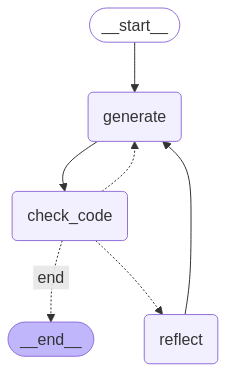

In [21]:
from IPython.display import Image, display

try:
    # display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass